# Data preprocessing 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import PIL
import os

## Locate paths of Images and Labels

In [2]:
# main folder 
ds_path = "carla-object-detection-dataset"

# Read text in .txt files
def read_txt(ds_path="", file_name="", label=False):
    file_path = os.path.join(ds_path, file_name)  
    with open(file_path, 'r') as file:
        content = file.read()   
    return content.split() if not label else [line for line in content.split('\n') if line] 

#### Output classes

In [3]:
classes = read_txt(ds_path, "labels.txt")
classes
print(f'There are total {len(classes)} classes which are {classes}')

There are total 5 classes which are ['vehicle', 'bike', 'motobike', 'traffic_light', 'traffic_sign']


#### Image's paths

In [4]:
train_img_paths = read_txt(ds_path, "train_yolo.txt")
trainval_img_paths = read_txt(ds_path, "trainval_yolo.txt")
val_img_paths = read_txt(ds_path, "val_yolo.txt")
test_img_paths = read_txt(ds_path, "test_yolo.txt")

## Adjust the file paths (because the .ipynb is not in the dataset's main folder)
train_img_paths = [os.path.join(ds_path, path[2:]) for path in train_img_paths]
trainval_img_paths = [os.path.join(ds_path, path[2:]) for path in trainval_img_paths]
val_img_paths = [os.path.join(ds_path, path[2:]) for path in val_img_paths]
test_img_paths = [os.path.join(ds_path, path[2:]) for path in test_img_paths]

## Correct images in the test folder (the original paths from test_yolo.txt points to 'train' folder)
def correct_test_path(path):
    new_path = path.split('/')
    new_path[2] = "test"
    return "/".join(new_path)

test_img_paths = [correct_test_path(path) for path in test_img_paths]


print(f'There are total {len(train_img_paths)} images for training')
print(f'There are total {len(trainval_img_paths)} images for train-val')
print(f'There are total {len(val_img_paths)} images for validation')
print(f'There are total {len(test_img_paths)} images for testing')

There are total 623 images for training
There are total 779 images for train-val
There are total 156 images for validation
There are total 249 images for testing


#### label's paths

In [5]:
label_path = os.path.join(ds_path, 'yolo_labels')

def label_dicts(label_path, dataset):
    file_path = os.path.join(label_path, dataset)
    label_dict = {}
    for root, dirs, files in os.walk(file_path):
        for file in files:
            img_file = os.path.splitext(file)[0] + ".png"
            label_dict[img_file] = os.path.join(root, file)
    return label_dict

train_label_paths = label_dicts(label_path, 'train')
test_label_paths = label_dicts(label_path, 'test')

print(f'There are total {len(train_label_paths)} labels for training')
print(f'There are total {len(test_label_paths)} labels for testing')

There are total 779 labels for training
There are total 249 labels for testing


## Create the YOLO dataset

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Resize

class YOLOdataset(Dataset):
    '''
    Process images and labels to YOLO dataset
    '''
    def __init__(self, img_paths, label_paths, img_size=280, 
                 grid_size=7, num_classes=len(classes), num_boxes=2, class_names=classes, transform=ToTensor()):
        self.img_paths = img_paths
        self.label_paths = label_paths
        self.img_size = img_size
        self.grid_size = grid_size
        self.num_classes = num_classes
        self.class_names = class_names
        self.num_boxes = num_boxes
        self.transform = transform
        self.resizing = Resize((img_size, img_size))

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img = PIL.Image.open(self.img_paths[idx])
        img_name = self.img_paths[idx].split("/")[-1]
        img_labels = read_txt(file_name=self.label_paths[img_name], label=True)

        # Resize image
        resized_img = self.resizing(img)

        # Transform image to tensor
        img_tensor = self.transform(resized_img)

        # Covert label to YOLO target : (x_center, y_center, bbox_w, bbox_h) => (x_cell, y_cell, bbox_w, bbox_h, Confidence, output_classes)
        targets = self.convert_to_yolo_target(img_labels)

        return img_tensor, targets  
    
    def show_rand_images(self):
        '''
        Show four random images from the image's path with corresponding bounding boxes
        ''' 
        # Get random indices 
        idx_1, idx_2, idx_3, idx_4 = [np.random.randint(0, len(self.img_paths)) for i in range(4)]
        
        # Open the images
        img_1, img_2 = PIL.Image.open(self.img_paths[idx_1]), PIL.Image.open(self.img_paths[idx_2])
        img_3, img_4 = PIL.Image.open(self.img_paths[idx_3]), PIL.Image.open(self.img_paths[idx_4])
        
        # Resize the images
        img_1, img_2, img_3, img_4 = self.resizing(img_1), self.resizing(img_2), self.resizing(img_3), self.resizing(img_4)

        # Get the image's names
        img_1_name, img_2_name = self.img_paths[idx_1].split("/")[-1], self.img_paths[idx_2].split("/")[-1]
        img_3_name, img_4_name = self.img_paths[idx_3].split("/")[-1], self.img_paths[idx_4].split("/")[-1]

        # Read the corresponding labels from txt files        
        label_1, label_2 = read_txt(file_name=self.label_paths[img_1_name], label=True), read_txt(file_name=self.label_paths[img_2_name], label=True)
        label_3, label_4 = read_txt(file_name=self.label_paths[img_3_name], label=True), read_txt(file_name=self.label_paths[img_4_name], label=True)


        # Plot images
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(8,7))
        ax1.imshow(img_1)
        self.get_bboxes(ax1, label_1)
        ax1.set_title(f"{img_1_name}, @index:{idx_1}")

        ax2.imshow(img_2)
        self.get_bboxes(ax2, label_2)
        ax2.set_title(f"{img_2_name}, @index:{idx_2}")

        ax3.imshow(img_3)
        self.get_bboxes(ax3, label_3)
        ax3.set_title(f"{img_3_name}, @index:{idx_3}")

        ax4.imshow(img_4)
        self.get_bboxes(ax4, label_4)
        ax4.set_title(f"{img_4_name}, @index:{idx_4}")
        
        ax1.axis('off')
        ax2.axis('off')
        ax3.axis('off')
        ax4.axis('off')   

    def get_bboxes(self, ax, image_labels):
        color_map = {'vehicle': 'orange', 
                     'bike': 'green', 
                     'motobike': 'blue',
                     'traffic_light':'red', 
                     'traffic_sign':'purple'}
        
        for label in image_labels:
            class_id, x_center, y_center, box_width, box_height = [float(i) for i in label.split()]
            # print(class_id, x_center, y_center, box_width, box_height)

            # Calculate top-left and bottom-right corners
            x_min = int((x_center - box_width/2) * self.img_size)
            y_min = int((y_center - box_height/2) * self.img_size)
            x_max = int((x_center + box_width/2) * self.img_size)
            y_max = int((y_center + box_height/2) * self.img_size)

            # Add each rectangle to the image axis
            color = color_map[self.class_names[int(class_id)]]
            rect = Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, linewidth=1, edgecolor=color, facecolor="none")
            ax.add_patch(rect)


    def reverse_to_yolo_label(self):
        '''
        Reverse the yolo_targets back to yolo labels
        '''        
        pass
      
    def convert_to_yolo_target(self, img_labels):    

        targets = np.zeros((self.grid_size, self.grid_size, self.num_boxes * 5 + self.num_classes)) ## target's shape = (7, 7, 15)   

        for label in img_labels:
            class_id, x_center, y_center, box_width, box_height = [float(i) for i in label.split()]
            # print(class_id, x_center, y_center, box_width, box_height)

            # Determine the grid cell (row, column) where the center of the bounding box belongs
            grid_y = int(y_center * self.grid_size)
            grid_x = int(x_center * self.grid_size)
            # print(grid_y, grid_x)

            # Convert to cell-relative coordinates
            x_cell = x_center * self.grid_size - grid_x
            y_cell = y_center * self.grid_size - grid_y
            # print(x_cell, y_cell)
            
            # Check both grid_x and grid_y are within grid_size
            if grid_x < self.grid_size and grid_y < self.grid_size:
                
                # Add a label into the first available box
                for box in range(self.num_boxes):
                    start_idx = box * 5
                    if targets[grid_y, grid_x, (start_idx + 4)] == 0:

                        ## Assign x, y, w, h to the cell ##
                            # Tensor indexing is row-major (y before x)
                            # Coordinate representation is Cartesian (x before y)                    
                        targets[grid_y, grid_x, start_idx:start_idx + 5] = [x_cell, y_cell, box_width, box_height, 1.0]

                        ## Set class one-hot encoding
                        targets[grid_y, grid_x, -self.num_classes + int(class_id)] = 1.0
                        break      
            # print(targets[grid_y, grid_x, :], '\n')       
        return targets

### Create train & test dataloaders

In [7]:
## Define global parameters
IMG_SIZE = 224                 
GRID_SIZE = 7
NUM_CLASSES = len(classes)
NUM_BOXES = 2
BATCH_SIZE = 32

train_data = YOLOdataset(trainval_img_paths, train_label_paths, img_size=IMG_SIZE, 
                         grid_size=GRID_SIZE, num_classes=NUM_CLASSES, num_boxes=NUM_BOXES)
test_data = YOLOdataset(test_img_paths, test_label_paths, img_size=IMG_SIZE, 
                         grid_size=GRID_SIZE, num_classes=NUM_CLASSES, num_boxes=NUM_BOXES)

a_image, a_label = train_data[0]
print(f'Image shape = {a_image.shape}')
print(f'Label shape = {a_label.shape}')

Image shape = torch.Size([4, 224, 224])
Label shape = (7, 7, 15)


In [8]:
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

len(train_dataloader), len(test_dataloader)

(25, 8)

In [9]:
# Check dataloader batch_images and batch_targets shape
for batch, (X, y) in enumerate(test_dataloader):
    print(X.shape)
    print(y.shape)    
    break

torch.Size([32, 4, 224, 224])
torch.Size([32, 7, 7, 15])


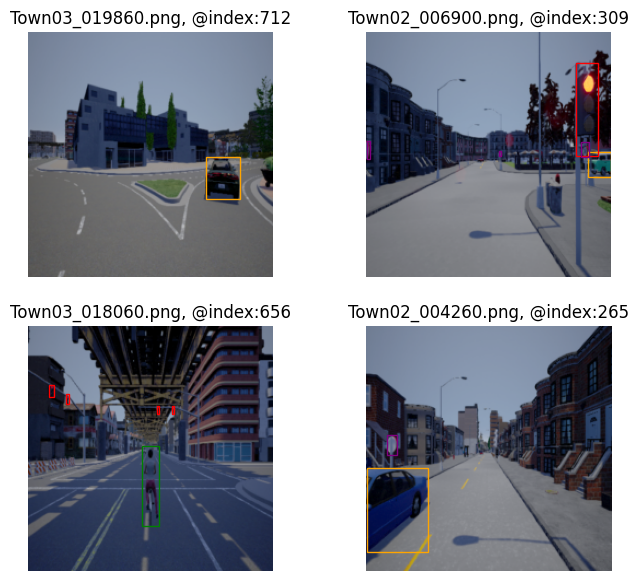

In [10]:
# Visualize four random images from the training data
train_data.show_rand_images()

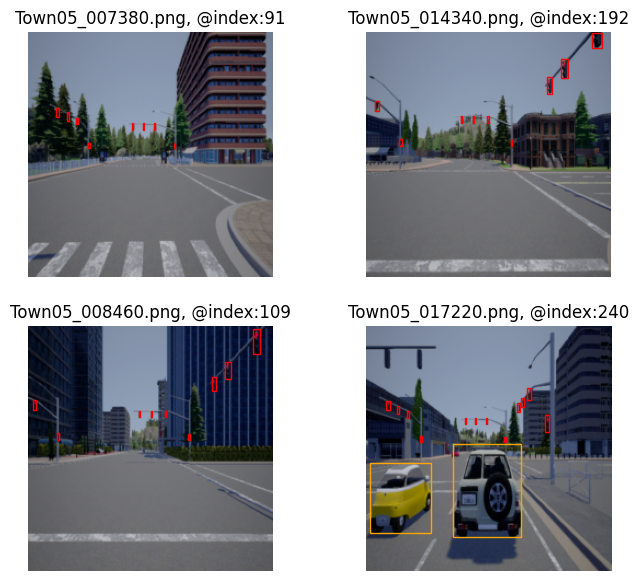

In [11]:
# Visualize four random images from the test data
test_data.show_rand_images()

# Building YOLO model

In [12]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


### Create Feature Extractor and Detection Head

In [13]:
from torchvision import models
from torch import nn

class EfficientNetFeatureExtractor(nn.Module):
    '''
    The feature extraction component is implemented using EfficientNet-B0 as a transfer learning backbone
    EfficientNet require image size = (224, 224) with 3 color channels and the output of feature extraction has shape = (batch, 1280)
    '''
    def __init__(self):
        super().__init__()
        self.efficientnet = models.get_model("efficientnet_b0", weights="IMAGENET1K_V1")
        # Remove the classification head 
        self.efficientnet.classifier = nn.Identity() 
        
        # Freeze the layers for transfer learning
        for param in self.efficientnet.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.efficientnet(x)

class DetectionHead(nn.Module):
    '''
    The detection head consists of multiple convolutional layers that process the feature maps to output predictions
    The output tensor shape = (batch, (5 * num_boxes + num_classes), grid_size, grid_size)
    '''
    def __init__(self, num_classes, num_boxes, grid_size):
        super().__init__()
        self.detection_head = nn.Sequential(
            nn.ConvTranspose2d(1280, 512, kernel_size=3),
            nn.BatchNorm2d(512),
            nn.ReLU(),    
            nn.Dropout(0.3),        
            nn.ConvTranspose2d(512, 64, kernel_size=grid_size), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.1),            
            nn.Conv2d(32, (5 * num_boxes + num_classes), kernel_size=3), # Output shape = (batch, (5 * num_boxes + num_classes), grid_size, grid_size)
            nn.ReLU()
        )
    def forward(self, x):
        return self.detection_head(x)

### Construct YOLO model

In [14]:
class YOLOModel(nn.Module):
    '''
    YOLO model consists of two main parts: feature extractor and detection head. 
    '''
    def __init__(self, num_classes=NUM_CLASSES, num_boxes=NUM_BOXES, grid_size=GRID_SIZE):
        super().__init__()
        self.num_classes = num_classes
        self.num_boxes = num_boxes
        self.grid_size = grid_size
        self.rgba_to_rgb = nn.Conv2d(in_channels=4, out_channels=3, kernel_size=1, stride=1, bias=False)
        self.feature_extractor = EfficientNetFeatureExtractor()
        self.detection_head = DetectionHead(self.num_classes, self.num_boxes, self.grid_size)

    def forward(self, x):
        x = self.rgba_to_rgb(x)
        features = self.feature_extractor(x)
        output = self.detection_head(features.view(-1, 1280, 1, 1))
        return output.permute(0, 2, 3, 1)
    
    def model_summary(self):
        '''
        Print the detection head's layers and the total trainable parameters 
        '''
        total_params = 0
        print(f"Trainable layers of detection_head include:")
        for name, param in self.detection_head.named_parameters():
            if param.requires_grad:
                print(f"Layer: {name} | Size: {param.size()} | Number of trainable parameters: {param.numel()}")
                total_params += param.numel()        
        print(f"\nThere are total {len(list(self.detection_head.named_parameters()))} layers with total trainable parameters = {total_params}")
    

class YOLOModel_FC(nn.Module):
    '''
    YOLO model with multiple fully connected layers acted as detection head 
    '''
    def __init__(self, num_classes=NUM_CLASSES, num_boxes=NUM_BOXES, grid_size=GRID_SIZE):
        super().__init__()
        self.num_classes = num_classes
        self.num_boxes = num_boxes
        self.grid_size = grid_size

        self.yolo = nn.Sequential(
            # Change channels from 4 to 3
            nn.Conv2d(in_channels=4, out_channels=3, 
                      kernel_size=1, stride=1, bias=False),
            EfficientNetFeatureExtractor(),
            nn.Flatten(),
            nn.Linear(1280, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Linear(512, self.grid_size * self.grid_size * (5 * self.num_boxes + self.num_classes)),
            nn.ReLU()
        )

    def model_summary(self):
        total_params = 0
        print(f"Trainable layers include:")
        for name, param in self.yolo.named_parameters():
            if param.requires_grad:
                print(f"Layer: {name} | Size: {param.size()} | Number of trainable parameters: {param.numel()}")
                total_params += param.numel()        
        print(f"\nThere are total {len(list(self.yolo.named_parameters()))} layers with total trainable parameters = {total_params}")

    def forward(self, x):
        y = self.yolo(x)
        return y.view(-1, self.grid_size, self.grid_size, (5 * self.num_boxes + self.num_classes))

In [15]:
yolo_model = YOLOModel().to(device)
yolo_model.model_summary()

Trainable layers of detection_head include:
Layer: detection_head.0.weight | Size: torch.Size([1280, 512, 3, 3]) | Number of trainable parameters: 5898240
Layer: detection_head.0.bias | Size: torch.Size([512]) | Number of trainable parameters: 512
Layer: detection_head.1.weight | Size: torch.Size([512]) | Number of trainable parameters: 512
Layer: detection_head.1.bias | Size: torch.Size([512]) | Number of trainable parameters: 512
Layer: detection_head.4.weight | Size: torch.Size([512, 64, 7, 7]) | Number of trainable parameters: 1605632
Layer: detection_head.4.bias | Size: torch.Size([64]) | Number of trainable parameters: 64
Layer: detection_head.5.weight | Size: torch.Size([64]) | Number of trainable parameters: 64
Layer: detection_head.5.bias | Size: torch.Size([64]) | Number of trainable parameters: 64
Layer: detection_head.8.weight | Size: torch.Size([32, 64, 3, 3]) | Number of trainable parameters: 18432
Layer: detection_head.8.bias | Size: torch.Size([32]) | Number of trainabl

In [16]:
# Verify the prediction shape
yolo_output = yolo_model(torch.rand(32, 4, 224, 224).to(device))
yolo_output.shape

torch.Size([32, 7, 7, 15])

### YOLO Loss Function

The YOLO loss function is designed to optimize three main objectives:

1. **Localization Loss**:   Ensures the predicted bounding box coordinates match the ground truth.
2. **Confidence Loss**:     Encourages the model to predict high confidence for objects and low confidence for background.
3. **Classification Loss**: Trains the model to correctly classify objects within a grid cell.

$$\text{Loss} = \lambda_{\text{coord}} \cdot \text{Localization Loss} + \text{Confidence Loss (Object)} + \lambda_{\text{noobj}} \cdot \text{Confidence Loss (No Object)} + \text{Classification Loss}$$

In [17]:
class YOLOLoss(nn.Module):
    def __init__(self, lambda_coord=10, lambda_noobj=0.25, num_boxes=NUM_BOXES, num_classes=NUM_CLASSES):
        super().__init__()
        self.lambda_coord = lambda_coord # weigth for coordinate loss
        self.lambda_noobj = lambda_noobj # Weight for no object confidence loss
        self.num_boxes = num_boxes
        self.num_classes = num_classes
        self.mse = nn.MSELoss(reduction='sum') # Mean Squared Error
        self.crossEn_loss = nn.CrossEntropyLoss(reduction='sum') # Cross Entropy Loss

    def forward(self, predictions, targets):
        '''
        Compute YOLO loss (according to the Loss formula)

        Args:
            predictions: Tensor of shape (batch_size, grid_size, grid_size, num_boxes*5 + num_classes), model output
            targets: Tensor of shape (batch_size, grid_size, grid_size, num_boxes*5 + num_classes), ground truth

        Returns:
            Total loss (scalar)
        '''
        
        # Extract elements from the predictions and targets
        pred_bboxes = []
        target_bboxes = []
        object_masks = []
        iou_ratios = []
        pred_classes = predictions[..., -self.num_classes:]
        target_classes = targets[..., -self.num_classes:]
        for i in range(self.num_boxes):            
            start_idx = i * 5
            pred_bboxes.append(predictions[..., start_idx:start_idx+5])            
            target_bboxes.append(targets[..., start_idx:start_idx+5])
            object_masks.append(targets[..., start_idx+4:start_idx+5])
            # Calculate IoU of each bounding box
            iou_ratio = self._iou(predictions[..., start_idx:start_idx+4], targets[..., start_idx:start_idx+4])
            iou_ratios.append(iou_ratio.unsqueeze(-1))
        
        # Find the bounding box with the highest IoU ratio    
        iou_ratios = torch.cat(iou_ratios, dim=-1)  # Concatenate IoU of each bounding box   
        best_box = torch.argmax(iou_ratios, dim=-1) 
        best_box = nn.functional.one_hot(best_box, num_classes=self.num_boxes) # Convert the bounding_box index to one-hot representation

        # Select the bounding box with the highest IoU for each grid cell  
        #--- Broadcasting the one-hot of bounding_boxes (batch, grid, grid, 1, one-hot) to the stack of prediction boxes (batch, grid, grid, 5, num_boxes))
        box_pred = torch.stack(pred_bboxes, dim=-1) * best_box.unsqueeze(-2) 
        box_target = torch.stack(target_bboxes, dim=-1) * best_box.unsqueeze(-2)

        # Sum all the bounding boxes
        box_pred = torch.sum(box_pred, dim=-1)
        box_target = torch.sum(box_target, dim=-1)  
        # print(f'box_pred shape = {box_pred.shape}')
        # print(f'box_target shape = {box_target.shape}')

        # Initialize losses
        localize_loss = 0
        conf_loss_obj = 0
        conf_loss_no_obj = 0
        class_loss = 0

        # An object_mask is from target's tensor, so the cell's value is either 1 or 0. It represents whether there is an object in each cell or not.  
        for obj_mask in object_masks:

            ### 1. Localization Loss ###
            xy_loss = self.mse(obj_mask * box_pred[..., :2], obj_mask * box_target[..., :2])            
            wh_loss = self.mse(obj_mask * torch.sqrt(box_pred[..., 2:4] + 1e-6), obj_mask * torch.sqrt(box_target[..., 2:4] + 1e-6))
            localize_loss += xy_loss + wh_loss
        
            ### 2. Confidence Loss ###
            conf_loss_obj += self.mse(obj_mask * box_pred[..., 4:5], obj_mask * box_target[..., 4:5])
            conf_loss_no_obj += self.mse((1 - obj_mask) * box_pred[..., 4:5], (1 - obj_mask) * box_target[..., 4:5])

            ### 3. Classification Loss ###
            y_hat = (obj_mask * pred_classes).permute(0, 3, 1, 2)
            y_true = (obj_mask * target_classes).permute(0, 3, 1, 2)
            class_loss += self.crossEn_loss(y_hat, y_true) # Input shape of 'CrossEntropyLoss' = (batch_size, num_classes, grid_size, grid_size)

        total_loss = (self.lambda_coord*localize_loss) + conf_loss_obj + (self.lambda_noobj*conf_loss_no_obj) + class_loss

        # print(f'Localization loss = {localize_loss:.2f}')
        # print(f'Confidence Loss (Object) = {conf_loss_obj:.2f}')
        # print(f'Confidence Loss (No Object) = {conf_loss_no_obj:.2f}')      
        # print(f'Classification Loss = {class_loss:.2f}')      
        # print(f'Total Loss = {total_loss:.2f}')
        return total_loss
    
    @staticmethod
    def _iou(pred_box, target_box):
        '''
        Compute IoU for two sets of bounding boxes
        Args:
            pred_box: Tensor of shape (..., 4) with x, y, w, h
            target_box: Tensor of shape (..., 4) with x, y, w, h
        Returns:
            IoU values for each pair of boxes    
        '''
        # Convert x, y, w, h to  x1, y1, x2, y2
        pred_box_x1 = pred_box[..., 0] - (pred_box[..., 2] / 2)
        pred_box_y1 = pred_box[..., 1] - (pred_box[..., 3] / 2) 
        pred_box_x2 = pred_box[..., 0] + (pred_box[..., 2] / 2)
        pred_box_y2 = pred_box[..., 1] + (pred_box[..., 3] / 2) 
        
        target_box_x1 = target_box[..., 0] - (target_box[..., 2] / 2)
        target_box_y1 = target_box[..., 1] - (target_box[..., 3] / 2)
        target_box_x2 = target_box[..., 0] + (target_box[..., 2] / 2)
        target_box_y2 = target_box[..., 1] + (target_box[..., 3] / 2)

        # Intersection (rectangle area = x*y)
        inter_x1 = torch.max(pred_box_x1, target_box_x1)
        inter_y1 = torch.max(pred_box_y1, target_box_y1)
        inter_x2 = torch.min(pred_box_x2, target_box_x2)
        inter_y2 = torch.min(pred_box_y2, target_box_y2)
        inter_area = torch.clamp(inter_x2 - inter_x1, min=0) * torch.clamp(inter_y2 - inter_y1, min=0) 

        # Union
        pred_box_area = torch.clamp(pred_box_x2 - pred_box_x1, min=0) * torch.clamp(pred_box_y2 - pred_box_y1, min=0)
        target_box_area = torch.clamp(target_box_x2 - target_box_x1, min=0) * torch.clamp(target_box_y2 - target_box_y1, min=0)
        union_area = pred_box_area + target_box_area - inter_area          
        return inter_area / (union_area + 1e-6) # Add small epsilon to aviod division by zero   

## IoU-based Accuracy and Class Accuracy

In [18]:
def iou_accuracy(predictions, targets, iou_threshold=0.5, num_classes=NUM_CLASSES, num_boxes=NUM_BOXES, iou_fn=YOLOLoss()._iou):
    '''
    Measures how well the predicted bounding boxes overlap with the ground truth boxes. 
    A prediction is considered accurate if its Intersection over Union (IoU) with the ground truth exceeds a predefined threshold (default = 0.5) 
    '''
    
    # Sum total objects from the targets (ground truth)
    total_objs = (targets[...,-num_classes:] == 1).float()
    total_objs = torch.sum(total_objs)
    acc_arr = []

    # Iterate over number of bounding boxes
    for i in range(num_boxes):            
        start_idx = i * 5
        # Calculate IoU ratio between predictions and targets 
        iou_ratio = iou_fn(predictions[..., start_idx:start_idx + 4], targets[..., start_idx:start_idx + 4])
        
        # Filter the predictions with IoU ratio higher than the threshold
        iou_mask = (iou_ratio > iou_threshold).float()
        detected_objs = torch.sum(iou_mask)

        # Calculate the accuracy [detected_objs / total_objs] of each bounding box
        acc_arr.append(detected_objs / total_objs if total_objs > 0 else 0.0)
    
    return torch.max(torch.tensor(acc_arr)) # return the highest accuracy
        
def class_accuracy(predictions, targets, num_classes=NUM_CLASSES):   
    '''
    Measures how accurately the model predicts the class of the objects detected.
    '''

    # Get the argmax of both predictions and targets 
    predictions_argMax = torch.argmax(predictions[..., -num_classes:], dim=-1) # shape = (batch, grid_size, grid_size)
    targets_argMax = torch.argmax(targets[..., -num_classes:], dim=-1) # shape = (batch, grid_size, grid_size)

    # Filter out cells without objects
    no_obj_cells = (torch.sum(targets[...,-num_classes:], dim=-1) == 0) # shape = (batch, grid_size, grid_size)
    filter_predictions_argMax = predictions_argMax[no_obj_cells] # shape = [batch * grid_size * grid_size]
    filter_targets_argMax = targets_argMax[no_obj_cells] # shape = [batch * grid_size * grid_size]

    # Calculate class accuracy
    correct_prediction = torch.sum((filter_predictions_argMax == filter_targets_argMax).float())
    return correct_prediction / len(filter_targets_argMax) if len(filter_targets_argMax) > 0 else 0.0

## Train YOLO model

In [19]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    training_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        training_loss += loss.item()

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 5 == 0:
            current = (batch + 1) * len(X)
            print(f'loss: {loss.item():.4f} [{current:>5d}/{size:>5d}]')
        
    training_loss /= len(dataloader)
    return training_loss

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, iou_acc, cls_acc = 0, 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # Make prediction
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            iou_acc += iou_accuracy(pred, y)
            cls_acc += class_accuracy(pred, y)
    
    test_loss /= num_batches
    iou_acc /= num_batches
    cls_acc /= num_batches
    print(f"Test Loss: \n Avg IoU Accuracy: {(100*iou_acc):.2f}%, Avg Class Accuracy: {(100*cls_acc):.2f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss  

In [22]:
training_losses, test_losses = [], []
EPOCH = 30
loss_fn = YOLOLoss()
optimizer = torch.optim.Adam(yolo_model.parameters(), lr=1e-3)

for i in range(EPOCH):
    print(f'Epoch {i+1}\n---------------------------')
    train_loss = train(train_dataloader, yolo_model, loss_fn, optimizer)
    test_loss = test(test_dataloader, yolo_model, loss_fn)
    training_losses.append(train_loss)
    test_losses.append(test_loss)
print("Done!")

Epoch 1
---------------------------
loss: 480.8576 [   32/  779]
loss: 420.1969 [  192/  779]
loss: 821.1544 [  352/  779]
loss: 1242.4930 [  512/  779]
loss: 1051.1111 [  672/  779]
Test Loss: 
 Avg IoU Accuracy: 0.00%, Avg Class Accuracy: 52.22%, Avg loss: 1674.529264 

Epoch 2
---------------------------
loss: 328.1063 [   32/  779]
loss: 353.2338 [  192/  779]
loss: 565.6387 [  352/  779]
loss: 1137.7408 [  512/  779]
loss: 871.7247 [  672/  779]
Test Loss: 
 Avg IoU Accuracy: 0.00%, Avg Class Accuracy: 62.06%, Avg loss: 1063.066763 

Epoch 3
---------------------------
loss: 281.3819 [   32/  779]
loss: 302.4809 [  192/  779]
loss: 502.4914 [  352/  779]
loss: 1037.4698 [  512/  779]
loss: 792.1708 [  672/  779]
Test Loss: 
 Avg IoU Accuracy: 0.00%, Avg Class Accuracy: 60.16%, Avg loss: 825.903069 

Epoch 4
---------------------------
loss: 259.6074 [   32/  779]
loss: 251.2424 [  192/  779]
loss: 394.0563 [  352/  779]
loss: 467.0188 [  512/  779]
loss: 467.3052 [  672/  779]
Tes

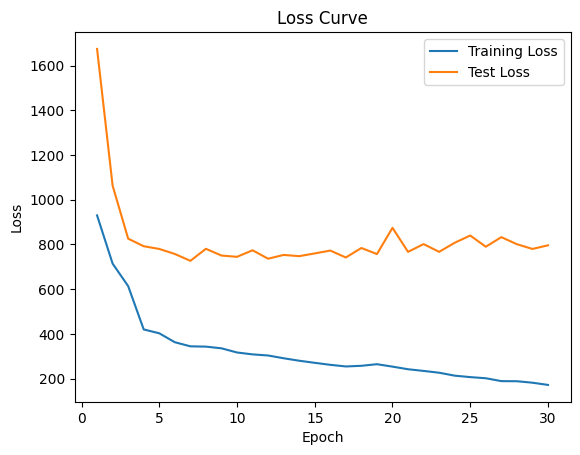

In [23]:
# Plot training and test loss curve 
plt.plot(range(1, EPOCH+1), training_losses, label="Training Loss")
plt.plot(range(1, EPOCH+1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

In [ ]:
# Visualize IoU and Class accuracy on one batch of the training data 
for X, y in train_dataloader:
    image = X.to(device)
    target = y.to(device)    
    pred = yolo_model(image)

    iou_acc, cls_acc = iou_accuracy(pred, target, iou_threshold=0.5), class_accuracy(pred, target)
    print(f'IoU accuracy = {(iou_acc*100):.2f}%')
    print(f'Class accuracy = {(cls_acc*100):.2f}%')
    break

IoU accuracy = 14.29%
Class accuracy = 56.29%


In [25]:
## Save the model's state dict
torch.save(yolo_model.state_dict(), "models_weights/modelV1_weights.pth")

In [27]:
## Load model's state dict
model = YOLOModel()
model.load_state_dict(torch.load("models_weights/modelV1_weights.pth", weights_only=True))
model.model_summary()

Trainable layers of detection_head include:
Layer: detection_head.0.weight | Size: torch.Size([1280, 512, 3, 3]) | Number of trainable parameters: 5898240
Layer: detection_head.0.bias | Size: torch.Size([512]) | Number of trainable parameters: 512
Layer: detection_head.1.weight | Size: torch.Size([512]) | Number of trainable parameters: 512
Layer: detection_head.1.bias | Size: torch.Size([512]) | Number of trainable parameters: 512
Layer: detection_head.4.weight | Size: torch.Size([512, 64, 7, 7]) | Number of trainable parameters: 1605632
Layer: detection_head.4.bias | Size: torch.Size([64]) | Number of trainable parameters: 64
Layer: detection_head.5.weight | Size: torch.Size([64]) | Number of trainable parameters: 64
Layer: detection_head.5.bias | Size: torch.Size([64]) | Number of trainable parameters: 64
Layer: detection_head.8.weight | Size: torch.Size([32, 64, 3, 3]) | Number of trainable parameters: 18432
Layer: detection_head.8.bias | Size: torch.Size([32]) | Number of trainabl